# 3. Diffusion Model Training 

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import random
import numpy as np
import json
import math
from torch.nn import functional as F
from dataclasses import dataclass
import pdb

# Set the random seed for replicability
seed = 940
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

def determine_max_seq_len(data, max_length='max_length'):
    """Calculate the max sequence length dynamically if 'max_length' is used as an argument."""
    if max_length == 'max_length':
        MAX_LENGTH = max(len(dp["tokens"]) for dp in data)
    else:
        MAX_LENGTH = max_length
    return MAX_LENGTH

def setup_device():
    """Set up the device for training."""
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def save_model(model, filepath):
    """Save the model's state dictionary."""
    torch.save(model.state_dict(), filepath)
    return model

def load_model(model, filepath):
    """Load a saved model state dictionary."""
    model.load_state_dict(torch.load(filepath))
    model.eval()
    device = setup_device()
    model.to(device)
    return model, device

def load_dataset(filepath):
    """Load the dataset from a JSON file."""
    with open(filepath, 'r') as file:
        dataset = [json.loads(line) for line in file]
    return dataset

def save_JSON(data, filename):
    """Save data to a JSON file."""
    with open(filename, 'w') as f:
        json.dump(data, f)
    return

def load_JSON(filename):
    """Load a JSON file."""
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

@dataclass
class tNetConfig:
    num_vars: int
    embedding_size: int

class tNet(nn.Module):
    def __init__(self, config: tNetConfig):
        super(tNet, self).__init__()

        self.config = config
        self.num_vars = config.num_vars
        self.n_embd = config.embedding_size

        self.activation_func = F.relu

        # Define the convolutional layers
        self.conv1 = nn.Conv1d(self.num_vars, self.n_embd, 1)
        self.conv2 = nn.Conv1d(self.n_embd, 2*self.n_embd, 1)
        self.conv3 = nn.Conv1d(2*self.n_embd, 4*self.n_embd, 1)

        # Define fully connected layers
        self.fc1 = nn.Linear(4*self.n_embd, 2*self.n_embd)
        self.fc2 = nn.Linear(2*self.n_embd, self.n_embd)

        # Corrected GroupNorm initialization
        self.input_batch_norm = nn.GroupNorm(1, self.num_vars)  # Corrected to match input channels
        
        # Define other GroupNorm layers
        self.bn1 = nn.GroupNorm(1, self.n_embd)
        self.bn2 = nn.GroupNorm(1, 2*self.n_embd)
        self.bn3 = nn.GroupNorm(1, 4*self.n_embd)
        self.bn4 = nn.GroupNorm(1, 2*self.n_embd)
        self.bn5 = nn.GroupNorm(1, self.n_embd)

    def forward(self, x):
        # Apply normalization and convolutions
        x = self.input_batch_norm(x)
        x = self.activation_func(self.bn1(self.conv1(x)))
        x = self.activation_func(self.bn2(self.conv2(x)))
        x = self.activation_func(self.bn3(self.conv3(x)))

        # Global max pooling
        x, _ = torch.max(x, dim=2)  # Reducing along the sequence dimension (index 2)
        assert x.size(1) == 4*self.n_embd  # Ensure correct output size

        # Apply fully connected layers
        x = self.activation_func(self.bn4(self.fc1(x)))
        x = self.activation_func(self.bn5(self.fc2(x)))
        return x

class CosineNoiseSchedule:
    def __init__(self, timesteps=1000, epsilon=1e-6, device=None):
        self.timesteps = timesteps
        self.epsilon = epsilon
        self.device = device
        
        # Create alphas using a cosine schedule
        self.alphas = torch.cos(torch.linspace(0, math.pi / 2, timesteps, device=device)) ** 2
        self.betas = 1.0 - self.alphas
        self.alpha_bar = torch.maximum(torch.cumprod(self.alphas, dim=0), torch.tensor(self.epsilon, device=self.alphas.device))

    def get_alpha(self, t):
        return self.alphas[t]

    def get_beta(self, t):
        return self.betas[t]

    def get_variance(self, t):
        return self.get_beta(t) * (1 - self.get_alpha(t))

    def get_alpha_bar(self, t):
        return self.alpha_bar[t]

class SymbolicRegressionDataset(Dataset):
    def __init__(self, data, vocab, max_seq_len, noise_schedule):
        self.data = data
        self.vocab = vocab  # Add vocab here
        self.max_seq_len = max_seq_len
        self.noise_schedule = noise_schedule

    def get_input_embeddings(self, tokens):
        embeddings = torch.stack([torch.tensor(token) for token in tokens])
        padded_embeddings = nn.functional.pad(embeddings, (0, self.max_seq_len - embeddings.size(0)))
        padded_embeddings = padded_embeddings.transpose(0,1)
        return padded_embeddings
    
    def add_noise(self, token_embeddings, t, schedule):
        alpha_t = schedule.get_alpha(t)
        beta_t = schedule.get_beta(t)
                
        noisy_embeddings = torch.sqrt(alpha_t)*token_embeddings + torch.sqrt(beta_t)*torch.randn_like(token_embeddings)
        return noisy_embeddings

    def __getitem__(self, idx):
        data_point = self.data[idx]
        tokens = data_point['tokens']
        current_data = data_point['data']
        # Map symbols to embeddings using vocab
        x = torch.tensor(current_data['x'], dtype=torch.float32)
        y = torch.tensor(current_data['y'], dtype=torch.float32)
        mask = torch.tensor(current_data['mask'], dtype=torch.float32)
        token_embeddings = self.get_input_embeddings(tokens)
        
        t = random.randint(0, self.noise_schedule.timesteps - 1)
        noisy_token_embeddings = self.add_noise(token_embeddings, t, self.noise_schedule)
        
        noisy_x = self.add_noise(x, t, self.noise_schedule)  # Fix: using the dataset's add_noise method
        noisy_y = self.add_noise(y, t, self.noise_schedule)  # Fix: using the dataset's add_noise method
        
        skeleton = data_point['skeleton']
        
        return token_embeddings, noisy_token_embeddings, noisy_x, noisy_y, t, mask, skeleton

    def __len__(self):
        return len(self.data)

class DiffusionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_heads, num_timesteps, max_seq_len=5000, pretrained_embeddings=None, tnet_config=None):
        super(DiffusionModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_timesteps = num_timesteps
        self.tnet = tNet(tnet_config) if tnet_config is not None else None

        if pretrained_embeddings is not None:
            pretrained_embeddings = torch.tensor(list(pretrained_embeddings.values()), dtype=torch.float32)
            if pretrained_embeddings.size(1) != embedding_dim:
                raise ValueError(
                    f"Pretrained embeddings size {pretrained_embeddings.size(1)} does not match the required embedding_dim {embedding_dim}."
                )
            self.embedding = nn.Parameter(pretrained_embeddings)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.projection = nn.Linear(embedding_dim, hidden_dim) if embedding_dim != hidden_dim else nn.Identity()
        self.layer_norm = nn.LayerNorm(hidden_dim, eps=1e-6)

        self.transformer = nn.Transformer(
            d_model=hidden_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            batch_first=False
        )
        
        self.fc_out = nn.Linear(hidden_dim, embedding_dim)

    def forward(self, embeddings):
        batch_size, hidden_dim, seq_len = embeddings.shape
        if self.embedding_dim != self.hidden_dim:
            embeddings = self.projection(embeddings)
        embeddings = embeddings.transpose(1, 2)
        embeddings = self.layer_norm(embeddings)
        embeddings = embeddings.transpose(0, 1)
        embeddings = self.transformer(embeddings, embeddings)
        embeddings = embeddings.transpose(0, 1)
        logits = self.fc_out(embeddings)
        logits = logits.transpose(1, 2)
        return logits
    
    def add_noise(self, token_embeddings, t, schedule):
        alpha_t = schedule.get_alpha(t)
        beta_t = schedule.get_beta(t)
                
        noisy_embeddings = torch.sqrt(alpha_t)*token_embeddings + torch.sqrt(beta_t)*torch.randn_like(token_embeddings)
        return noisy_embeddings
    
    def reverse_diffusion(self, noisy_input, schedule):
        x_t = noisy_input
        device = x_t.device
        for t in reversed(range(self.num_timesteps)):
            predicted_noise = self.tnet(x_t) if self.tnet is not None else self.forward(x_t)
            #predicted_noise = self.forward(x_t)
            alpha_t = schedule.get_alpha(t)
            beta_t = schedule.get_beta(t)
            mean_x_prev = (x_t - beta_t * predicted_noise) / torch.sqrt(alpha_t)
            if t > 0:
                std_dev = torch.sqrt(beta_t)
                noise = torch.randn_like(x_t, device=device) * std_dev
                x_t = mean_x_prev + noise
            else:
                x_t = mean_x_prev
            x_t = torch.clamp(x_t, min=-1.0, max=1.0)
        return x_t

def denoising_loss(predicted_embeddings, clean_embeddings):
    return nn.MSELoss()(predicted_embeddings, clean_embeddings)

def train_diffusion_model(model, train_loader, val_loader, num_epochs=10, patience_num_epochs=3):
    device = setup_device()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    #optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=2,factor=0.5)
    schedule = CosineNoiseSchedule(timesteps=1000, device=device)

    best_val_loss = float('inf')
    num_epochs_without_improvement = 0
    early_stopping = False
    performance_metrics = {"epoch_list": [], "train_loss_list": [], "val_loss_list": []}
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for token_embeddings, noisy_token_embeddings, x, y, t, mask, skeleton in train_loader:
            token_embeddings, noisy_token_embeddings, x, y, mask = token_embeddings.to(device), noisy_token_embeddings.to(device), x.to(device), y.to(device), mask.to(device)
            mask = mask.to(device) if mask is not None else None
            optimizer.zero_grad()
            predicted_embeddings = model(noisy_token_embeddings)
            loss = denoising_loss(predicted_embeddings, token_embeddings)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        train_loss = total_loss/len(train_loader)
        performance_metrics['train_loss_list'].append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for token_embeddings, noisy_token_embeddings, x, y, t, mask, skeleton in val_loader:
                token_embeddings, noisy_token_embeddings, x, y, mask = token_embeddings.to(device), noisy_token_embeddings.to(device), x.to(device), y.to(device), mask.to(device)
                mask = mask.to(device) if mask is not None else None

                # Forward pass
                denoised_token_embeddings = model.reverse_diffusion(noisy_token_embeddings, schedule)
                
                # Compute loss
                loss = denoising_loss(denoised_token_embeddings, token_embeddings)
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        performance_metrics['val_loss_list'].append(val_loss)
        performance_metrics['epoch_list'].append(epoch + 1)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        #scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(model, "Data/best_diffusion_model_method1.pt")
            num_epochs_without_improvement = 0
        else:
            num_epochs_without_improvement += 1

        if num_epochs_without_improvement >= patience_num_epochs:
            print(f"Training stopped early at epoch {epoch + 1}. Best validation loss: {best_val_loss}")
            early_stopping = True
            break
        
    if early_stopping == False:
        save_model(model, "../Data/best_diffusion_model_method1.pt")

    return model, performance_metrics

# Example of loading and preparing the dataset
dataset = load_dataset('Data/preprocessed_data_with_embeddings.json')
vocab = load_JSON("Data/vocab_embeddings.json")  # Vocabulary is a dictionary of continuous embeddings

MAX_LENGTH = determine_max_seq_len(dataset)  # Determine the max length dynamically

schedule = CosineNoiseSchedule(timesteps=1000,device=setup_device())

# First, perform the split on the raw dataset
train_size = int(0.7*len(dataset))  # 70% for training
val_size = int(0.15*len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - val_size  # 15% for testing

# Perform random split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset_SR = SymbolicRegressionDataset(train_dataset, vocab, MAX_LENGTH, schedule)
val_dataset_SR = SymbolicRegressionDataset(val_dataset, vocab, MAX_LENGTH, schedule)
test_dataset_SR = SymbolicRegressionDataset(test_dataset, vocab, MAX_LENGTH, schedule)

# Create DataLoader objects for each subset
train_loader = DataLoader(train_dataset_SR, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset_SR, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset_SR, batch_size=16, shuffle=True)

# Initialize the model
num_heads = 4  # Number of attention heads, ensure this is a divisor of embedding_dim
embedding_dim = 100  # The embedding dimension is 100 as per your problem
hidden_dim = embedding_dim  # Hidden dimension stays the same for simplicity

# Ensure embedding_dim is divisible by num_heads
if embedding_dim % num_heads != 0:
    raise ValueError(f"embedding_dim ({embedding_dim}) must be divisible by num_heads ({num_heads}).")

model = DiffusionModel(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=4,
    num_heads=4,
    num_timesteps=1000,
    pretrained_embeddings=vocab
)

model,performance_metrics_DICT = train_diffusion_model(model,train_loader,val_loader,num_epochs=100,patience_num_epochs=10)

Epoch 1/100, Train Loss: 0.23779887557029725, Val Loss: 0.4486483931541443
Epoch 2/100, Train Loss: 0.10243501961231231, Val Loss: 0.4412689507007599
Epoch 3/100, Train Loss: 0.059051104635000226, Val Loss: 0.43448907136917114
Epoch 4/100, Train Loss: 0.03806477934122086, Val Loss: 0.42765307426452637
Epoch 5/100, Train Loss: 0.028167488798499108, Val Loss: 0.42596903443336487
Epoch 6/100, Train Loss: 0.023289132118225097, Val Loss: 0.4268840551376343
Epoch 7/100, Train Loss: 0.02140187583863735, Val Loss: 0.42439475655555725
Epoch 8/100, Train Loss: 0.019652978330850602, Val Loss: 0.4292699992656708
Epoch 9/100, Train Loss: 0.01858958601951599, Val Loss: 0.42538952827453613
Epoch 10/100, Train Loss: 0.01812881454825401, Val Loss: 0.42740288376808167
Epoch 11/100, Train Loss: 0.01749928668141365, Val Loss: 0.4254731237888336
Epoch 12/100, Train Loss: 0.017029761523008346, Val Loss: 0.42796412110328674
Epoch 13/100, Train Loss: 0.01678049601614475, Val Loss: 0.42996978759765625
Epoch 14

### Plotting Results

In [29]:
import matplotlib.pyplot as plt

#Visualize the train and validation loss
def plot_train_valid(model_name,performance_metrics_DICT):
    plt.figure();
    plt.plot(performance_metrics_DICT['epoch_list'], performance_metrics_DICT['train_loss_list'], label=f'Train Loss', color='blue', linestyle='--', marker='o');
    plt.plot(performance_metrics_DICT['epoch_list'], performance_metrics_DICT['val_loss_list'], label=f'Validation Loss', color='green', linestyle='-', marker='x');
    plt.title(f'{model_name} Training and Validation Loss');
    plt.xlabel('Epochs');
    plt.ylabel('Loss');
    plt.legend();
    plt.grid();
    plt.xlim(0,max(performance_metrics_DICT['epoch_list'])+1);
    return

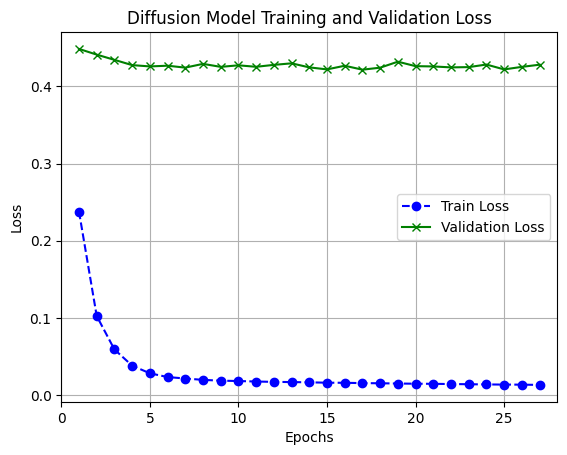

In [30]:
model_name = 'Diffusion Model'

plot_train_valid(model_name,performance_metrics_DICT)

### Prediction

In [1]:
def decode_embeddings_to_tokens(embeddings, vocab):
    batch_size, embedding_dim, seq_length = embeddings.shape
    vocab_embeddings = torch.stack([torch.tensor(embed) for embed in vocab.values()])  # Shape: [embedding_dim, num_symbols]

    # Reshape vocab_embeddings to shape: [num_symbols, embedding_dim] for broadcasting    
    # Compute the pairwise distance between each embedding in the sequence and all vocab embeddings
    # embeddings: [batch_size, embedding_dim, seq_length]
    # vocab_embeddings: [num_symbols, embedding_dim]
    
    # To compute pairwise distances, we need to reshape embeddings to [batch_size * seq_length, embedding_dim]
    embeddings_flattened = embeddings.view(batch_size * seq_length, embedding_dim)
    
    # Compute pairwise distances using cdist (shape: [batch_size * seq_length, num_symbols])
    distances = torch.cdist(embeddings_flattened, vocab_embeddings)  # Shape: [batch_size * seq_length, num_symbols]

    # Reshape distances back to [batch_size, seq_length, num_symbols]
    distances = distances.view(batch_size, seq_length, -1)
    
    # Find the index of the closest token for each position in the sequence
    closest_token_indices = torch.argmin(distances, dim=-1)  # Shape: [batch_size, seq_length]
    
    # Convert indices to tokens
    decoded_tokens = []
    for batch_idx in range(batch_size):
        tokens = [list(vocab.keys())[idx.item()] for idx in closest_token_indices[batch_idx]]
        decoded_tokens.append(tokens)

    return decoded_tokens

def evaluate_diffusion_model(model, test_loader, vocab, schedule, device):
    model.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    decoded_formulas = []
    actual_formulas = []

    with torch.no_grad():
        for token_embeddings, noisy_token_embeddings, x, y, t, mask, skeleton_list in test_loader:
            token_embeddings, noisy_token_embeddings, x, y, mask = token_embeddings.to(device), noisy_token_embeddings.to(device), x.to(device), y.to(device), mask.to(device)
            # Get the predicted denoised embeddings
            t = random.randint(0, model.num_timesteps - 1)  # Random timestep for diffusion
            pred_embeddings = model.reverse_diffusion(noisy_token_embeddings, schedule)

            # Calculate the loss (MSE between predicted and target embeddings)
            loss = denoising_loss(pred_embeddings, noisy_token_embeddings)
            total_test_loss += loss.item()

            # Now, we need to decode the denoised embeddings back to tokens
            decoded_tokens_list = decode_embeddings_to_tokens(pred_embeddings, vocab)

            # Convert the decoded tokens to a formula string
            predicted_formula = ["".join(decoded_tokens).replace('<PAD>', '').replace('+', ' + ') for decoded_tokens in decoded_tokens_list]
            decoded_formulas.append(predicted_formula)

            # Assuming target embeddings have a corresponding ground truth formula (you can adjust this part)
            actual_formula = list(skeleton_list)
            actual_formulas.append(actual_formula)

    # Calculate average test loss
    avg_test_loss = total_test_loss/len(test_loader)
    return avg_test_loss, decoded_formulas, actual_formulas

# Example of loading and preparing the dataset
dataset = load_dataset('Data/preprocessed_data_with_embeddings.json')
vocab = load_JSON("Data/vocab_embeddings.json")  # Vocabulary is a dictionary of continuous embeddings

MAX_LENGTH = determine_max_seq_len(dataset)  # Determine the max length dynamically

schedule = CosineNoiseSchedule(timesteps=1000,device=setup_device())

# First, perform the split on the raw dataset
train_size = int(0.7*len(dataset))  # 70% for training
val_size = int(0.15*len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - val_size  # 15% for testing

# Perform random split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset_SR = SymbolicRegressionDataset(train_dataset, vocab, MAX_LENGTH, schedule)
val_dataset_SR = SymbolicRegressionDataset(val_dataset, vocab, MAX_LENGTH, schedule)
test_dataset_SR = SymbolicRegressionDataset(test_dataset, vocab, MAX_LENGTH, schedule)

# Create DataLoader objects for each subset
train_loader = DataLoader(train_dataset_SR, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset_SR, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset_SR, batch_size=16, shuffle=True)

# Initialize the model
num_heads = 4  # Number of attention heads, ensure this is a divisor of embedding_dim
embedding_dim = 100  # The embedding dimension is 100 as per your problem
hidden_dim = embedding_dim  # Hidden dimension stays the same for simplicity

# Ensure embedding_dim is divisible by num_heads
if embedding_dim % num_heads != 0:
    raise ValueError(f"embedding_dim ({embedding_dim}) must be divisible by num_heads ({num_heads}).")

model = DiffusionModel(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=4,
    num_heads=4,
    num_timesteps=1000,
    pretrained_embeddings=vocab
)

# Example: Evaluate the model on the test set
model, device = load_model(model, "Data/best_diffusion_model_method1.pt")
test_loss, decoded_formulas, actual_formulas = evaluate_diffusion_model(model, test_loader, vocab, schedule, device)

# Print out the average test loss
print(f"Test Loss: {test_loss}")

# Print out the first few decoded formulas and their corresponding actual formulas
for predicted, actual in zip(decoded_formulas[:5], actual_formulas[:5]):
    print(f"Predicted Formula: {predicted}")
    print(f"Actual Formula: {actual}")
    print("-"*50)

NameError: name 'load_dataset' is not defined

# Alternate Attempt

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import random
import numpy as np
import json
import math
from torch.nn import functional as F
from dataclasses import dataclass
import pdb

# Set the random seed for replicability
seed = 940
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

def determine_max_seq_len(data, max_length='max_length'):
    """Calculate the max sequence length dynamically if 'max_length' is used as an argument."""
    if max_length == 'max_length':
        MAX_LENGTH = max(len(dp["tokens"]) for dp in data)
    else:
        MAX_LENGTH = max_length
    return MAX_LENGTH

def setup_device():
    """Set up the device for training."""
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def save_model(model, filepath):
    """Save the model's state dictionary."""
    torch.save(model.state_dict(), filepath)
    return model

def load_model(model, filepath):
    """Load a saved model state dictionary."""
    model.load_state_dict(torch.load(filepath))
    model.eval()
    device = setup_device()
    model.to(device)
    return model, device

def load_dataset(filepath):
    """Load the dataset from a JSON file."""
    with open(filepath, 'r') as file:
        dataset = [json.loads(line) for line in file]
    return dataset

def load_dataset_torch(filepath):
    loaded_data = torch.load(filepath)
    formula_embeddings = loaded_data['formula_embeddings']
    dataset_embeddings = loaded_data['dataset_embeddings']
    return formula_embeddings,dataset_embeddings

def save_JSON(data, filename):
    """Save data to a JSON file."""
    with open(filename, 'w') as f:
        json.dump(data, f)
    return

def load_JSON(filename):
    """Load a JSON file."""
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

@dataclass
class tNetConfig:
    num_vars: int
    embedding_size: int

class tNet(nn.Module):
    def __init__(self, config: tNetConfig):
        super(tNet, self).__init__()

        self.config = config
        self.num_vars = config.num_vars
        self.n_embd = config.embedding_size

        self.activation_func = F.relu

        # Define the convolutional layers
        self.conv1 = nn.Conv1d(self.num_vars, self.n_embd, 1)
        self.conv2 = nn.Conv1d(self.n_embd, 2*self.n_embd, 1)
        self.conv3 = nn.Conv1d(2*self.n_embd, 4*self.n_embd, 1)

        # Define fully connected layers
        self.fc1 = nn.Linear(4*self.n_embd, 2*self.n_embd)
        self.fc2 = nn.Linear(2*self.n_embd, self.n_embd)

        # Corrected GroupNorm initialization
        self.input_batch_norm = nn.GroupNorm(1, self.num_vars)  # Corrected to match input channels
        
        # Define other GroupNorm layers
        self.bn1 = nn.GroupNorm(1, self.n_embd)
        self.bn2 = nn.GroupNorm(1, 2*self.n_embd)
        self.bn3 = nn.GroupNorm(1, 4*self.n_embd)
        self.bn4 = nn.GroupNorm(1, 2*self.n_embd)
        self.bn5 = nn.GroupNorm(1, self.n_embd)

    def forward(self, x):
        # Apply normalization and convolutions
        if len(x.shape) == 2:  # If no batch dimension
            x = x.unsqueeze(0)  # Add batch dimension
        
        x = self.input_batch_norm(x)
        x = self.activation_func(self.bn1(self.conv1(x)))
        x = self.activation_func(self.bn2(self.conv2(x)))
        x = self.activation_func(self.bn3(self.conv3(x)))

        # Global max pooling
        x, _ = torch.max(x, dim=2)  # Reducing along the sequence dimension (index 2)
        assert x.size(1) == 4*self.n_embd  # Ensure correct output size

        # Apply fully connected layers
        x = self.activation_func(self.bn4(self.fc1(x)))
        x = self.activation_func(self.bn5(self.fc2(x)))
        return x

class CosineNoiseSchedule:
    def __init__(self, timesteps=1000, epsilon=1e-6, device=None):
        self.timesteps = timesteps
        self.epsilon = epsilon
        self.device = device
        
        # Create alphas using a cosine schedule
        self.alphas = torch.cos(torch.linspace(0, math.pi/2, timesteps, device=device))**2
        self.betas = 1.0 - self.alphas
        self.alpha_bar = torch.maximum(torch.cumprod(self.alphas, dim=0), torch.tensor(self.epsilon, device=self.alphas.device))

    def get_alpha(self, t):
        return self.alphas[t]

    def get_beta(self, t):
        return self.betas[t]

    def get_variance(self, t):
        return self.get_beta(t) * (1 - self.get_alpha(t))

    def get_alpha_bar(self, t):
        return self.alpha_bar[t]

class SymbolicRegressionDataset(Dataset):
    def __init__(self, preprocessed_data, vocab, max_seq_len, noise_schedule):
        self.preprocessed_data = preprocessed_data
        self.vocab = vocab  # Add vocab here
        self.max_seq_len = max_seq_len
        self.noise_schedule = noise_schedule
    
    def add_noise(self, embeddings, t):
        """Add noise to the embeddings based on the cosine noise schedule."""
        alpha_t = self.noise_schedule.get_alpha(t)
        beta_t = self.noise_schedule.get_beta(t)
        noise = torch.randn_like(embeddings)*torch.sqrt(beta_t)
        noisy_embeddings = torch.sqrt(alpha_t)*embeddings + noise
        return noisy_embeddings

    def __getitem__(self, idx):
        """Prepare a single data point."""
        data_point = self.preprocessed_data[idx]
        formula_emb = torch.tensor(data_point['formula_embedding'], dtype=torch.float32)
        dataset_emb =  torch.tensor(data_point['dataset_embedding'], dtype=torch.float32)
        skeleton = data_point['skeleton']

        # Sample a timestep t
        t = random.randint(0, self.noise_schedule.timesteps - 1)
        noisy_formula_emb = self.add_noise(formula_emb, t)
        return formula_emb, noisy_formula_emb, dataset_emb, t, skeleton

    def __len__(self):
        return len(self.preprocessed_data)

class DiffusionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_heads, num_timesteps, max_seq_len=5000, pretrained_embeddings=None):
        super(DiffusionModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_timesteps = num_timesteps
                
        # Initialize embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.projection = nn.Linear(embedding_dim, hidden_dim) if embedding_dim != hidden_dim else nn.Identity()
        self.layer_norm = nn.LayerNorm(hidden_dim, eps=1e-6)

        self.transformer = nn.Transformer(
            d_model=hidden_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            batch_first=False
        )
        
        # Cross-attention mechanism for conditioning
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=hidden_dim, 
            num_heads=num_heads, 
            batch_first=True
        )

        self.fc_out = nn.Linear(hidden_dim, embedding_dim)
        
    def forward(self, embeddings):
        # Process embeddings
        batch_size, embedding_dim = embeddings.shape
        embeddings = self.projection(embeddings)
        embeddings = self.layer_norm(embeddings)
        embeddings = embeddings.unsqueeze(0)  # Shape: (1, batch_size, hidden_dim)
        embeddings = self.transformer(embeddings, embeddings)  # Shape: (1, batch_size, hidden_dim)
        embeddings = embeddings.squeeze(0)  # Shape: (batch_size, hidden_dim)
        logits = self.fc_out(embeddings)  # Shape: (batch_size, output_dim)
        return logits

    def reverse_diffusion(self, noisy_formula_embeddings, dataset_embeddings, schedule):
        """Reverse diffusion process using attention-based conditioning."""
        device = noisy_formula_embeddings.device
        batch_size, embedding_dim = noisy_formula_embeddings.size()
        x_t = noisy_formula_embeddings
        
        tnet = tNet(tNetConfig(num_vars=batch_size,embedding_size=embedding_dim))
        
        # Expand dimensions for cross-attention
        dataset_embeddings = dataset_embeddings.unsqueeze(1)  # Add sequence dimension (e.g., [B, D] -> [B, 1, D])
        
        for t in reversed(range(self.num_timesteps)):
            # Predict the noise using cross-attention
            query = x_t.unsqueeze(1)  # [B, 1, D]
            conditioned_embedding, _ = self.cross_attention(
                query=query,
                key=dataset_embeddings,
                value=dataset_embeddings
            )
            x_t = conditioned_embedding.squeeze(1)  # Remove sequence dimension
            
            # Use conditioned_embedding to predict noise
            predicted_noise = tnet(x_t) if tnet is not None else self.forward(x_t) 

            # Extract alpha and beta values from schedule
            alpha_t = schedule.get_alpha(t)
            beta_t = schedule.get_beta(t)
            
            # Compute mean of x_{t-1}
            mean_x_prev = (x_t - beta_t * predicted_noise) / torch.sqrt(alpha_t)
            
            if t > 0:
                std_dev = torch.sqrt(beta_t)
                noise = torch.randn_like(x_t, device=device) * std_dev
                x_t = mean_x_prev + noise
            else:
                x_t = mean_x_prev
            
            # Clamp values to avoid out-of-bound values
            x_t = torch.clamp(x_t, min=-1.0, max=1.0)
        
        return x_t

def denoising_loss(predicted_embeddings, clean_embeddings):
    return nn.MSELoss()(predicted_embeddings, clean_embeddings)

def train_diffusion_model(model, train_loader, val_loader, num_epochs=10, patience_num_epochs=3):
    device = setup_device()
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
    schedule = CosineNoiseSchedule(timesteps=1000, device=device)

    best_val_loss = float('inf')
    num_epochs_without_improvement = 0
    early_stopping = False
    performance_metrics = {"epoch_list": [], "train_loss_list": [], "val_loss_list": []}

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for formula_emb, noisy_formula_emb, dataset_emb, t, skeleton in train_loader:
            formula_emb, noisy_formula_emb, dataset_emb = formula_emb.to(device), noisy_formula_emb.to(device), dataset_emb.to(device)

            optimizer.zero_grad()

            # Predict the denoised formula embeddings using the model
            predicted_emb = model(noisy_formula_emb)

            # Compute the loss using the original clean formula embeddings
            loss = denoising_loss(predicted_emb, formula_emb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        train_loss = total_loss/len(train_loader)
        performance_metrics['train_loss_list'].append(train_loss)

        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        total_correct = 0
        num_samples = 0

        with torch.no_grad():  # No gradients needed during validation
            for formula_emb, noisy_formula_emb, dataset_emb, t, skeleton in val_loader:
                formula_emb, noisy_formula_emb, dataset_emb = formula_emb.to(device), noisy_formula_emb.to(device), dataset_emb.to(device)
                predicted_emb = model.reverse_diffusion(noisy_formula_emb, dataset_emb, schedule)
                loss = denoising_loss(predicted_emb, formula_emb)
                val_loss += loss.item()

                num_samples += formula_emb.size(0)

        val_loss = val_loss/len(val_loader)
        performance_metrics['val_loss_list'].append(val_loss)
        performance_metrics['epoch_list'].append(epoch + 1)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(model, "best_diffusion_model_method2.pt")
            num_epochs_without_improvement = 0
        else:
            num_epochs_without_improvement += 1

        if num_epochs_without_improvement >= patience_num_epochs:
            print(f"Training stopped early at epoch {epoch + 1}. Best validation loss: {best_val_loss}")
            early_stopping = True
            break

    if not early_stopping:
        save_model(model, "best_diffusion_model_method2.pt")

    return model, performance_metrics

# Example of loading and preparing the dataset
dataset = load_dataset('Data/preprocessed_data_with_embeddings.json')
vocab = load_JSON("Data/vocab_embeddings.json")  # Vocabulary is a dictionary of continuous embeddings

MAX_LENGTH = determine_max_seq_len(dataset)  # Determine the max length dynamically

schedule = CosineNoiseSchedule(timesteps=1000,device=setup_device())

# First, perform the split on the raw dataset
train_size = int(0.7*len(dataset))  # 70% for training
val_size = int(0.15*len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - val_size  # 15% for testing

# Perform random split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset_SR = SymbolicRegressionDataset(train_dataset, vocab, MAX_LENGTH, schedule)
val_dataset_SR = SymbolicRegressionDataset(val_dataset, vocab, MAX_LENGTH, schedule)
test_dataset_SR = SymbolicRegressionDataset(test_dataset, vocab, MAX_LENGTH, schedule)

# Create DataLoader objects for each subset
train_loader = DataLoader(train_dataset_SR, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset_SR, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset_SR, batch_size=16, shuffle=True)

# Initialize the model
num_heads = 4  # Number of attention heads, ensure this is a divisor of embedding_dim
embedding_dim = 128  # The embedding dimension is 100 as per your problem
hidden_dim = embedding_dim  # Hidden dimension stays the same for simplicity

# Ensure embedding_dim is divisible by num_heads
if embedding_dim % num_heads != 0:
    raise ValueError(f"embedding_dim ({embedding_dim}) must be divisible by num_heads ({num_heads}).")

model = DiffusionModel(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=4,
    num_heads=4,
    num_timesteps=1000,
    pretrained_embeddings=vocab,
)

model,performance_metrics_DICT = train_diffusion_model(model,train_loader,val_loader,num_epochs=100,patience_num_epochs=100)

Epoch 1/100, Train Loss: 0.7206235289573669, Val Loss: 0.6199209690093994
Epoch 2/100, Train Loss: 0.46560250520706176, Val Loss: 0.6199209690093994
Epoch 3/100, Train Loss: 0.3378569185733795, Val Loss: 0.6199209690093994
Epoch 4/100, Train Loss: 0.2589802235364914, Val Loss: 0.6199209690093994
Epoch 5/100, Train Loss: 0.214978489279747, Val Loss: 0.6199209690093994
Epoch 6/100, Train Loss: 0.1942541182041168, Val Loss: 0.6199209690093994
Epoch 7/100, Train Loss: 0.17953898012638092, Val Loss: 0.6199209690093994
Epoch 8/100, Train Loss: 0.17081521451473236, Val Loss: 0.6199209690093994
Epoch 9/100, Train Loss: 0.16131505072116853, Val Loss: 0.6199209690093994
Epoch 10/100, Train Loss: 0.1597515672445297, Val Loss: 0.6199209690093994
Epoch 11/100, Train Loss: 0.14926388263702392, Val Loss: 0.6199209690093994
Epoch 12/100, Train Loss: 0.1479350209236145, Val Loss: 0.6199209690093994
Epoch 13/100, Train Loss: 0.14628997445106506, Val Loss: 0.6199209690093994
Epoch 14/100, Train Loss: 0.1

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import random
import numpy as np
import json
import math
from torch.nn import functional as F
from dataclasses import dataclass
import pdb

# Set the random seed for replicability
seed = 940
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

def determine_max_seq_len(data, max_length='max_length'):
    """Calculate the max sequence length dynamically if 'max_length' is used as an argument."""
    if max_length == 'max_length':
        MAX_LENGTH = max(len(dp["tokens"]) for dp in data)
    else:
        MAX_LENGTH = max_length
    return MAX_LENGTH

def setup_device():
    """Set up the device for training."""
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def save_model(model, filepath):
    """Save the model's state dictionary."""
    torch.save(model.state_dict(), filepath)
    return model

def load_model(model, filepath):
    """Load a saved model state dictionary."""
    model.load_state_dict(torch.load(filepath))
    model.eval()
    device = setup_device()
    model.to(device)
    return model, device

def load_dataset(filepath):
    """Load the dataset from a JSON file."""
    with open(filepath, 'r') as file:
        dataset = [json.loads(line) for line in file]
    return dataset

def save_JSON(data, filename):
    """Save data to a JSON file."""
    with open(filename, 'w') as f:
        json.dump(data, f)
    return

def load_JSON(filename):
    """Load a JSON file."""
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

@dataclass
class tNetConfig:
    num_vars: int
    embedding_size: int

class tNet(nn.Module):
    def __init__(self, config: tNetConfig):
        super(tNet, self).__init__()

        self.config = config
        self.num_vars = config.num_vars
        self.n_embd = config.embedding_size

        self.activation_func = F.relu

        # Define the convolutional layers
        self.conv1 = nn.Conv1d(self.num_vars, self.n_embd, 1)
        self.conv2 = nn.Conv1d(self.n_embd, 2*self.n_embd, 1)
        self.conv3 = nn.Conv1d(2*self.n_embd, 4*self.n_embd, 1)

        # Define fully connected layers
        self.fc1 = nn.Linear(4*self.n_embd, 2*self.n_embd)
        self.fc2 = nn.Linear(2*self.n_embd, self.n_embd)

        # Corrected GroupNorm initialization
        self.input_batch_norm = nn.GroupNorm(1, self.num_vars)  # Corrected to match input channels
        
        # Define other GroupNorm layers
        self.bn1 = nn.GroupNorm(1, self.n_embd)
        self.bn2 = nn.GroupNorm(1, 2*self.n_embd)
        self.bn3 = nn.GroupNorm(1, 4*self.n_embd)
        self.bn4 = nn.GroupNorm(1, 2*self.n_embd)
        self.bn5 = nn.GroupNorm(1, self.n_embd)

    def forward(self, x):
        # Apply normalization and convolutions
        if len(x.shape) == 2:  # If no batch dimension
            x = x.unsqueeze(0)  # Add batch dimension
        
        x = self.input_batch_norm(x)
        x = self.activation_func(self.bn1(self.conv1(x)))
        x = self.activation_func(self.bn2(self.conv2(x)))
        x = self.activation_func(self.bn3(self.conv3(x)))

        # Global max pooling
        x, _ = torch.max(x, dim=2)  # Reducing along the sequence dimension (index 2)
        assert x.size(1) == 4*self.n_embd  # Ensure correct output size

        # Apply fully connected layers
        x = self.activation_func(self.bn4(self.fc1(x)))
        x = self.activation_func(self.bn5(self.fc2(x)))
        return x


def add_noise_with_data(embeddings, dataset_points, t, schedule):
    """Add noise to embeddings using dataset points."""
    alpha_t = schedule.get_alpha(t)
    beta_t = schedule.get_beta(t)
    noise = torch.randn_like(embeddings) * torch.sqrt(beta_t)
    noisy_embeddings = torch.sqrt(alpha_t) * embeddings + noise + dataset_points.mean(dim=0)
    return noisy_embeddings

class CosineNoiseSchedule:
    def __init__(self, timesteps=1000, epsilon=1e-6, device=None):
        self.timesteps = timesteps
        self.epsilon = epsilon
        self.device = device
        
        # Create alphas using a cosine schedule
        self.alphas = torch.cos(torch.linspace(0, math.pi/2, timesteps, device=device))**2
        self.betas = 1.0 - self.alphas
        self.alpha_bar = torch.maximum(torch.cumprod(self.alphas, dim=0), torch.tensor(self.epsilon, device=self.alphas.device))

    def get_alpha(self, t):
        return self.alphas[t]

    def get_beta(self, t):
        return self.betas[t]

    def get_variance(self, t):
        return self.get_beta(t) * (1 - self.get_alpha(t))

    def get_alpha_bar(self, t):
        return self.alpha_bar[t]

class SymbolicRegressionDataset(Dataset):
    def __init__(self, preprocessed_data, vocab, max_seq_len, noise_schedule):
        self.preprocessed_data = preprocessed_data
        self.vocab = vocab
        self.max_seq_len = max_seq_len
        self.noise_schedule = noise_schedule
    
    def add_noise(self, embeddings, dataset_points, t):
        """Add noise to embeddings based on data points."""
        return add_noise_with_data(embeddings, dataset_points, t, self.noise_schedule)

    def __getitem__(self, idx):
        """Prepare a single data point."""
        data_point = self.preprocessed_data[idx]
        formula_emb = torch.tensor(data_point['formula_embedding'], dtype=torch.float32)
        dataset_emb = torch.tensor(data_point['dataset_embedding'], dtype=torch.float32)
        skeleton = data_point['skeleton']

        # Sample a timestep t
        t = random.randint(0, self.noise_schedule.timesteps - 1)
        noisy_formula_emb = self.add_noise(formula_emb, dataset_emb, t)
        return formula_emb, noisy_formula_emb, dataset_emb, t, skeleton

    def __len__(self):
        return len(self.preprocessed_data)

class DiffusionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_heads, num_timesteps, pretrained_embeddings=None):
        super(DiffusionModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_timesteps = num_timesteps
        
        # Initialize embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.projection = nn.Linear(embedding_dim, hidden_dim) if embedding_dim != hidden_dim else nn.Identity()
        self.layer_norm = nn.LayerNorm(hidden_dim, eps=1e-6)
        
        self.transformer = nn.Transformer(
            d_model=hidden_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            batch_first=False
        )
        
        # Cross-attention mechanism for conditioning
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=hidden_dim, 
            num_heads=num_heads, 
            batch_first=True
        )

        self.fc_out = nn.Linear(hidden_dim, embedding_dim)
        
    def forward(self, embeddings):
        """Standard forward pass."""
        embeddings = self.projection(embeddings)
        embeddings = self.layer_norm(embeddings)
        embeddings = embeddings.unsqueeze(0)  # Add sequence dimension
        embeddings = self.transformer(embeddings, embeddings)
        embeddings = embeddings.squeeze(0)  # Remove sequence dimension
        logits = self.fc_out(embeddings)
        return logits

    def reverse_diffusion(self, noisy_formula_embeddings, dataset_embeddings, schedule):
        """Reverse diffusion process using attention-based conditioning."""
        device = noisy_formula_embeddings.device
        batch_size, embedding_dim = noisy_formula_embeddings.size()
        x_t = noisy_formula_embeddings
        
        tnet = tNet(tNetConfig(num_vars=batch_size,embedding_size=embedding_dim))
        
        dataset_embeddings = dataset_embeddings.unsqueeze(1)  # Add sequence dimension
        
        for t in reversed(range(self.num_timesteps)):
            # Predict the noise using cross-attention
            query = x_t.unsqueeze(1)  # Shape: [B, 1, D]
            conditioned_embedding, _ = self.cross_attention(
                query=query,
                key=dataset_embeddings,
                value=dataset_embeddings
            )
            x_t = conditioned_embedding.squeeze(1)  # Remove sequence dimension
            
            # Use conditioned_embedding to predict noise
            predicted_noise = tnet(x_t) if tnet is not None else self.forward(x_t) 
            
            # Extract alpha and beta values
            alpha_t = schedule.get_alpha(t)
            beta_t = schedule.get_beta(t)
            
            # Compute mean of x_{t-1}
            mean_x_prev = (x_t - beta_t*predicted_noise)/torch.sqrt(alpha_t)
            
            if t > 0:
                std_dev = torch.sqrt(beta_t)
                noise = torch.randn_like(x_t, device=device) * std_dev
                x_t = mean_x_prev + noise
            else:
                x_t = mean_x_prev
            
            # Clamp values
            x_t = torch.clamp(x_t, min=-1.0, max=1.0)
        
        return x_t

# Update the training process if needed
def train_diffusion_model(model, train_loader, val_loader, num_epochs=10, patience_num_epochs=3):
    device = setup_device()
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
    schedule = CosineNoiseSchedule(timesteps=1000, device=device)
    
    best_val_loss = float('inf')
    num_epochs_without_improvement = 0
    early_stopping = False
    performance_metrics = {"epoch_list": [], "train_loss_list": [], "val_loss_list": []}

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for formula_emb, noisy_formula_emb, dataset_emb, t, skeleton in train_loader:
            formula_emb, noisy_formula_emb, dataset_emb = formula_emb.to(device), noisy_formula_emb.to(device), dataset_emb.to(device)

            optimizer.zero_grad()
            predicted_emb = model(noisy_formula_emb)
            loss = denoising_loss(predicted_emb, formula_emb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        performance_metrics['train_loss_list'].append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for formula_emb, noisy_formula_emb, dataset_emb, t, skeleton in val_loader:
                formula_emb, noisy_formula_emb, dataset_emb = formula_emb.to(device), noisy_formula_emb.to(device), dataset_emb.to(device)
                predicted_emb = model.reverse_diffusion(noisy_formula_emb, dataset_emb, schedule)
                loss = denoising_loss(predicted_emb, formula_emb)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        performance_metrics['val_loss_list'].append(val_loss)
        performance_metrics['epoch_list'].append(epoch + 1)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(model, "best_diffusion_model.pt")
            num_epochs_without_improvement = 0
        else:
            num_epochs_without_improvement += 1

        if num_epochs_without_improvement >= patience_num_epochs:
            print(f"Training stopped early at epoch {epoch + 1}. Best validation loss: {best_val_loss}")
            early_stopping = True
            break

    if not early_stopping:
        save_model(model, "best_diffusion_model.pt")

    return model, performance_metrics

# Example of loading and preparing the dataset
dataset = load_dataset('Data/preprocessed_data_with_embeddings.json')
vocab = load_JSON("Data/vocab_embeddings.json")  # Vocabulary is a dictionary of continuous embeddings

MAX_LENGTH = determine_max_seq_len(dataset)  # Determine the max length dynamically

schedule = CosineNoiseSchedule(timesteps=1000,device=setup_device())

# First, perform the split on the raw dataset
train_size = int(0.7*len(dataset))  # 70% for training
val_size = int(0.15*len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - val_size  # 15% for testing

# Perform random split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset_SR = SymbolicRegressionDataset(train_dataset, vocab, MAX_LENGTH, schedule)
val_dataset_SR = SymbolicRegressionDataset(val_dataset, vocab, MAX_LENGTH, schedule)
test_dataset_SR = SymbolicRegressionDataset(test_dataset, vocab, MAX_LENGTH, schedule)

# Create DataLoader objects for each subset
train_loader = DataLoader(train_dataset_SR, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset_SR, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset_SR, batch_size=16, shuffle=True)

# Initialize the model
num_heads = 4  # Number of attention heads, ensure this is a divisor of embedding_dim
embedding_dim = 128  # The embedding dimension is 100 as per your problem
hidden_dim = embedding_dim  # Hidden dimension stays the same for simplicity

# Ensure embedding_dim is divisible by num_heads
if embedding_dim % num_heads != 0:
    raise ValueError(f"embedding_dim ({embedding_dim}) must be divisible by num_heads ({num_heads}).")

model = DiffusionModel(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=4,
    num_heads=4,
    num_timesteps=1000,
    pretrained_embeddings=vocab,
)

model,performance_metrics_DICT = train_diffusion_model(model,train_loader,val_loader,num_epochs=100,patience_num_epochs=100)


Epoch 1/100, Train Loss: 0.7206235289573669, Val Loss: 0.6199209690093994
Epoch 2/100, Train Loss: 0.4656024813652039, Val Loss: 0.6199209690093994
Epoch 3/100, Train Loss: 0.33785690665245055, Val Loss: 0.6199209690093994
Epoch 4/100, Train Loss: 0.2589802086353302, Val Loss: 0.6199209690093994
Epoch 5/100, Train Loss: 0.21497848331928254, Val Loss: 0.6199209690093994
Epoch 6/100, Train Loss: 0.19425413012504578, Val Loss: 0.6199209690093994
Epoch 7/100, Train Loss: 0.1795389920473099, Val Loss: 0.6199209690093994
Epoch 8/100, Train Loss: 0.17081521153450013, Val Loss: 0.6199209690093994
Epoch 9/100, Train Loss: 0.16131505072116853, Val Loss: 0.6199209690093994
Epoch 10/100, Train Loss: 0.15975157022476197, Val Loss: 0.6199209690093994
Epoch 11/100, Train Loss: 0.1492638885974884, Val Loss: 0.6199209690093994
Epoch 12/100, Train Loss: 0.14793502986431123, Val Loss: 0.6199209690093994
Epoch 13/100, Train Loss: 0.14628996849060058, Val Loss: 0.6199209690093994
Epoch 14/100, Train Loss: 